In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE
from imblearn.pipeline import make_pipeline

In [26]:
postural_labels = ['SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_SIT', 'SIT_TO_STAND']

df = pd.read_csv('dataset.csv')
df = df.loc[df['Activity'].isin(postural_labels)]

X = df.drop(columns=['Activity'])
y = df['Activity']

dcopy = df.copy()
dcopy['Activity'] = [
    1 if a == 'STAND_TO_SIT'
    else 2 if a == 'SIT_TO_STAND'
    else 3 if a == 'SIT_TO_LIE'
    else 4
    for a in dcopy['Activity']
]

metrics = ['f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'accuracy']

## Distribuição de classes

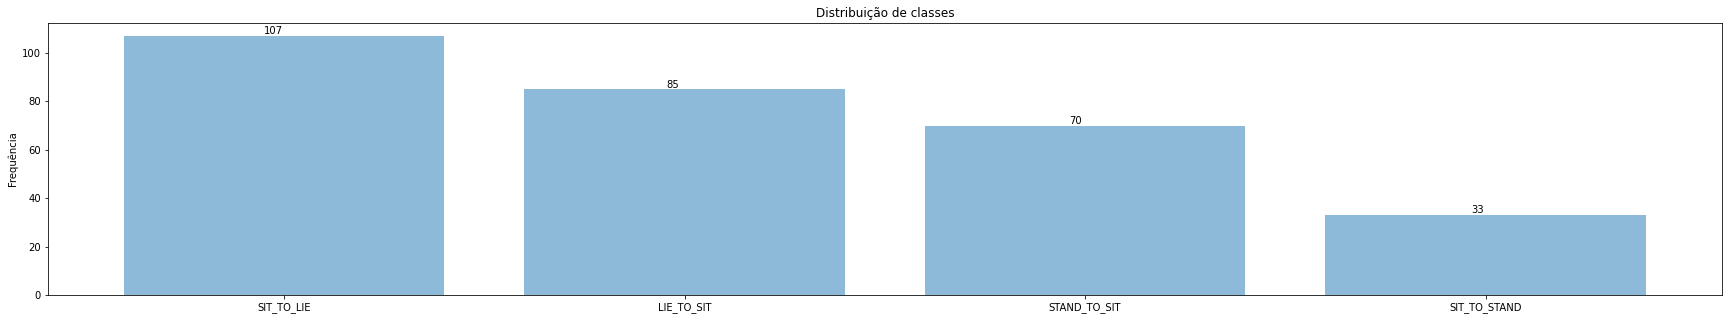

In [3]:
counts = y.value_counts()
bar_y = counts.index.to_list()
bar_x = counts.tolist()
y_pos = np.arange(len(bar_y))

plt.subplots(figsize=(30,5))
plt.bar(y_pos, bar_x, align='center', alpha = 0.5)
plt.xticks(y_pos, bar_y)
xlocs, xlabs = plt.xticks()
plt.ylabel('Frequência')
plt.title('Distribuição de classes')
for i, v in enumerate(bar_x):
    plt.text(xlocs[i] - 0.05 + i*0.005, v + 0.7, str(v))

## Scatter plot

In [4]:
# Pre-Process data

tsne_data = X.copy()
label = y.copy()

# Scale data so it has mean = 0, std = 1
scl = StandardScaler()
# and scale every entry to [0,1] range
tsne_data = scl.fit_transform(tsne_data)
# so that the sparse data is centered

# Reduce dimensions (speed up)
# uses SVD (Singular Value Decomposition)
# to linear dimensionality reduction (projection)
# requires not sparsed data
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
# t-distributed stochastic neighbor embedding
# nonlinear dimensionality reduction to high dim data
# for visulation on low dim spaces
tsne = TSNE(random_state=42, n_jobs=-1)
tsne_transformed = tsne.fit_transform(tsne_data)


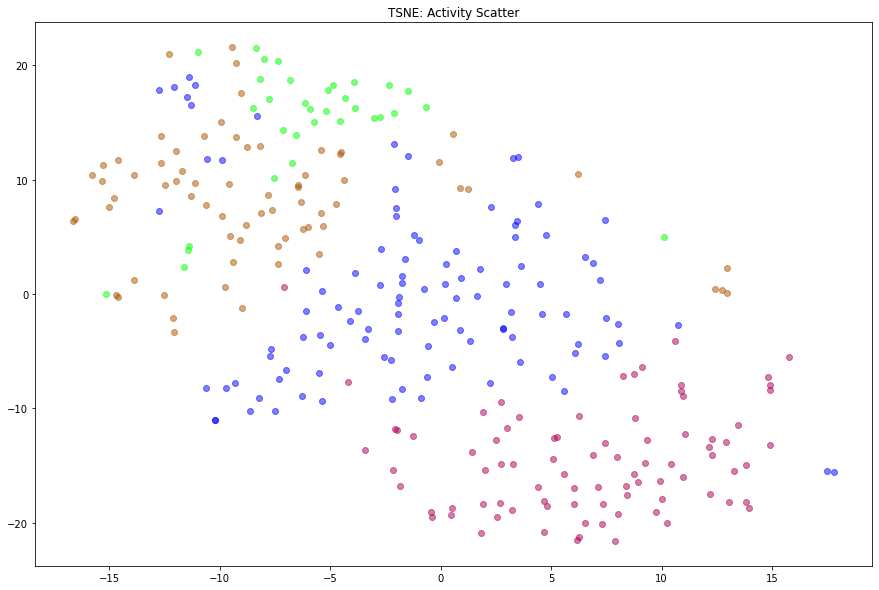

In [5]:
## Plot Activities

# Create subplots
plt.subplots(figsize=(15,10))

# Get colors
n = label.unique().shape[0]
colormap = get_cmap('brg')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label.value_counts().index):
    # Mask to separate sets
    mask = (label==group).values
    # ax[0]
    plt.scatter(
        x=tsne_transformed[mask][:,0],
        y=tsne_transformed[mask][:,1],
        c=colors[i],
        alpha=0.5,
        label=group
    )
plt.title('TSNE: Activity Scatter')
plt.show()

## KNN

In [6]:
knn_results = []

# KNN classifiers with odd K in range of (1,19)
# search for best K
for i in range(10):
    k = i*2+1
    knnClass = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    result = cross_validate(knnClass, X, y, cv=10, scoring=metrics,
                            return_train_score=True, n_jobs=-1)
    knn_results.append(result)
    print("k = " + str(k) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# spoiler it's: 7

k = 1:
	f1:
		mean = 95.28%;
		std = 0.02;
	ROC AUC OneVsRest:
		mean = 97.05%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 96.95%;
		std = 0.01;
	balanced accuracy:
		mean = 95.30%;
		std = 0.02;
	accuracy:
		mean = 95.25%;
		std = 0.02;
k = 3:
	f1:
		mean = 96.29%;
		std = 0.02;
	ROC AUC OneVsRest:
		mean = 98.92%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 98.98%;
		std = 0.01;
	balanced accuracy:
		mean = 96.34%;
		std = 0.02;
	accuracy:
		mean = 96.26%;
		std = 0.02;
k = 5:
	f1:
		mean = 95.91%;
		std = 0.03;
	ROC AUC OneVsRest:
		mean = 99.15%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 99.16%;
		std = 0.01;
	balanced accuracy:
		mean = 96.26%;
		std = 0.03;
	accuracy:
		mean = 95.92%;
		std = 0.03;
k = 7:
	f1:
		mean = 96.26%;
		std = 0.03;
	ROC AUC OneVsRest:
		mean = 99.62%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 99.61%;
		std = 0.01;
	balanced accuracy:
		mean = 96.61%;
		std = 0.03;
	accuracy:
		mean = 96.25%;
		std = 0.03;
k = 9:
	f1:
		mean = 95.88%;
		std = 0.04;
	ROC AUC 

## KNN report

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)
knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  LIE_TO_SIT       1.00      1.00      1.00        26
  SIT_TO_LIE       1.00      0.94      0.97        32
SIT_TO_STAND       0.90      0.90      0.90        10
STAND_TO_SIT       0.91      1.00      0.95        21

    accuracy                           0.97        89
   macro avg       0.95      0.96      0.96        89
weighted avg       0.97      0.97      0.97        89



## Decision Tree

In [8]:
tree_results = []

# Search for the best tree depth
for i in range(1, 17):
    curr = DecisionTreeClassifier(random_state=42, max_depth=i)
    result = cross_validate(curr, X, y, cv=10, scoring=metrics,
                            return_train_score=True, n_jobs=-1)
    tree_results.append(result)
    print("Depth = " + str(i) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# spoiler it's 4

Depth = 1:
	f1:
		mean = 52.22%;
		std = 0.02;
	ROC AUC OneVsRest:
		mean = 77.53%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 74.52%;
		std = 0.02;
	balanced accuracy:
		mean = 49.10%;
		std = 0.01;
	accuracy:
		mean = 64.07%;
		std = 0.02;
Depth = 2:
	f1:
		mean = 79.63%;
		std = 0.08;
	ROC AUC OneVsRest:
		mean = 92.31%;
		std = 0.06;
	ROC AUC OneVsOne:
		mean = 89.30%;
		std = 0.07;
	balanced accuracy:
		mean = 71.19%;
		std = 0.08;
	accuracy:
		mean = 83.34%;
		std = 0.07;
Depth = 3:
	f1:
		mean = 88.39%;
		std = 0.10;
	ROC AUC OneVsRest:
		mean = 95.50%;
		std = 0.06;
	ROC AUC OneVsOne:
		mean = 94.49%;
		std = 0.07;
	balanced accuracy:
		mean = 85.50%;
		std = 0.13;
	accuracy:
		mean = 88.39%;
		std = 0.09;
Depth = 4:
	f1:
		mean = 90.30%;
		std = 0.09;
	ROC AUC OneVsRest:
		mean = 94.39%;
		std = 0.06;
	ROC AUC OneVsOne:
		mean = 93.34%;
		std = 0.07;
	balanced accuracy:
		mean = 87.87%;
		std = 0.11;
	accuracy:
		mean = 90.11%;
		std = 0.09;
Depth = 5:
	f1:
		mean = 87.65%;
		s

## Decision Tree Report

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)
dtree = DecisionTreeClassifier(random_state=42, max_depth=4)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  LIE_TO_SIT       0.96      0.88      0.92        26
  SIT_TO_LIE       0.97      0.94      0.95        32
SIT_TO_STAND       0.80      0.80      0.80        10
STAND_TO_SIT       0.83      0.95      0.89        21

    accuracy                           0.91        89
   macro avg       0.89      0.89      0.89        89
weighted avg       0.91      0.91      0.91        89



## MLP

In [10]:
for i in range(1,11):
    mpl = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 600,
                    hidden_layer_sizes=(i*50,),
                    random_state=42)

    result = cross_validate(mpl, X, y, cv=10, scoring=metrics,
                            return_train_score=True, n_jobs=-1)
    print("Hidden Layers = " + str(mpl.hidden_layer_sizes[0]) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# best hidden layer size: 400

Hidden Layers = 50:
	f1:
		mean = 95.55%;
		std = 0.04;
	ROC AUC OneVsRest:
		mean = 99.63%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 99.66%;
		std = 0.01;
	balanced accuracy:
		mean = 95.32%;
		std = 0.05;
	accuracy:
		mean = 95.59%;
		std = 0.04;
Hidden Layers = 100:
	f1:
		mean = 95.89%;
		std = 0.04;
	ROC AUC OneVsRest:
		mean = 99.62%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 99.64%;
		std = 0.01;
	balanced accuracy:
		mean = 95.60%;
		std = 0.05;
	accuracy:
		mean = 95.92%;
		std = 0.04;
Hidden Layers = 150:
	f1:
		mean = 95.55%;
		std = 0.04;
	ROC AUC OneVsRest:
		mean = 99.65%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 99.67%;
		std = 0.01;
	balanced accuracy:
		mean = 95.32%;
		std = 0.05;
	accuracy:
		mean = 95.59%;
		std = 0.04;
Hidden Layers = 200:
	f1:
		mean = 95.55%;
		std = 0.04;
	ROC AUC OneVsRest:
		mean = 99.65%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 99.67%;
		std = 0.01;
	balanced accuracy:
		mean = 95.32%;
		std = 0.05;
	accuracy:
		mean = 95.59%;
		std = 0.0

## MLP Report

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)
mlp = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 600,
                    hidden_layer_sizes=(400,),
                    random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  LIE_TO_SIT       1.00      0.96      0.98        26
  SIT_TO_LIE       1.00      0.94      0.97        32
SIT_TO_STAND       0.83      1.00      0.91        10
STAND_TO_SIT       0.95      1.00      0.98        21

    accuracy                           0.97        89
   macro avg       0.95      0.97      0.96        89
weighted avg       0.97      0.97      0.97        89



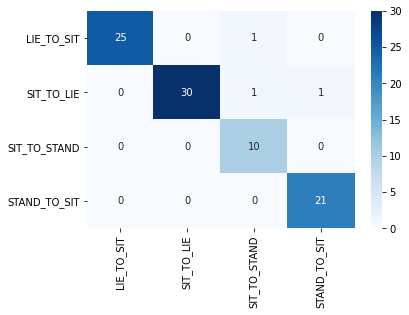

In [12]:
cf_matrix = confusion_matrix(y_test, y_pred)

categories = np.unique(y).tolist()
figsize = plt.rcParams.get('figure.figsize')
plt.figure(figsize=figsize)
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)

## KNN with Oversampling

In [27]:
for i in range(10):
    k = i*2+1
    knnClass = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    steps = [SMOTE(random_state=42, n_jobs=-1), knnClass]
    imba_pipeline = make_pipeline(*steps)

    result = cross_validate(imba_pipeline, X, y, cv=10, scoring=metrics, n_jobs=-1)

    print("k = " + str(k) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# spoiler it's: 1

k = 1:
	f1:
		mean = 95.67%;
		std = 0.03;
	ROC AUC OneVsRest:
		mean = 97.31%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 97.39%;
		std = 0.02;
	balanced accuracy:
		mean = 96.14%;
		std = 0.02;
	accuracy:
		mean = 95.59%;
		std = 0.03;
k = 3:
	f1:
		mean = 95.08%;
		std = 0.03;
	ROC AUC OneVsRest:
		mean = 98.18%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 98.24%;
		std = 0.01;
	balanced accuracy:
		mean = 95.44%;
		std = 0.03;
	accuracy:
		mean = 94.93%;
		std = 0.03;
k = 5:
	f1:
		mean = 94.76%;
		std = 0.03;
	ROC AUC OneVsRest:
		mean = 98.94%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 99.05%;
		std = 0.01;
	balanced accuracy:
		mean = 95.09%;
		std = 0.03;
	accuracy:
		mean = 94.59%;
		std = 0.03;
k = 7:
	f1:
		mean = 94.13%;
		std = 0.04;
	ROC AUC OneVsRest:
		mean = 99.14%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 99.25%;
		std = 0.01;
	balanced accuracy:
		mean = 94.61%;
		std = 0.04;
	accuracy:
		mean = 93.90%;
		std = 0.04;
k = 9:
	f1:
		mean = 93.43%;
		std = 0.04;
	ROC AUC 

## KNN with oversampling Report

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)

knnClass = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
steps = [SMOTE(random_state=42, n_jobs=-1), knnClass]
imba_pipeline = make_pipeline(*steps)
imba_pipeline.fit(X_train, y_train)
y_pred = imba_pipeline.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  LIE_TO_SIT       1.00      0.96      0.98        26
  SIT_TO_LIE       0.97      0.94      0.95        32
SIT_TO_STAND       0.77      1.00      0.87        10
STAND_TO_SIT       1.00      0.95      0.98        21

    accuracy                           0.96        89
   macro avg       0.93      0.96      0.94        89
weighted avg       0.96      0.96      0.96        89



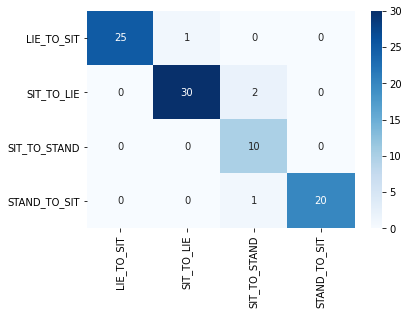

In [29]:
cf_matrix = confusion_matrix(y_test, y_pred)

categories = np.unique(y).tolist()
figsize = plt.rcParams.get('figure.figsize')
plt.figure(figsize=figsize)
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)

## KNN with ADASYN Oversampling

In [30]:
for i in range(10):
    k = i*2+1
    knnClass = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    steps = [ADASYN(random_state=42, n_jobs=-1), knnClass]
    imba_pipeline = make_pipeline(*steps)

    result = cross_validate(imba_pipeline, X, y, cv=10, scoring=metrics, n_jobs=-1)

    print("k = " + str(k) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# spoiler it's: 1

k = 1:
	f1:
		mean = 94.65%;
		std = 0.03;
	ROC AUC OneVsRest:
		mean = 96.68%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 96.61%;
		std = 0.02;
	balanced accuracy:
		mean = 94.82%;
		std = 0.04;
	accuracy:
		mean = 94.57%;
		std = 0.03;
k = 3:
	f1:
		mean = 93.65%;
		std = 0.05;
	ROC AUC OneVsRest:
		mean = 97.80%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 97.89%;
		std = 0.01;
	balanced accuracy:
		mean = 93.86%;
		std = 0.05;
	accuracy:
		mean = 93.55%;
		std = 0.05;
k = 5:
	f1:
		mean = 92.73%;
		std = 0.04;
	ROC AUC OneVsRest:
		mean = 98.24%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 98.28%;
		std = 0.01;
	balanced accuracy:
		mean = 92.94%;
		std = 0.05;
	accuracy:
		mean = 92.55%;
		std = 0.04;
k = 7:
	f1:
		mean = 93.04%;
		std = 0.05;
	ROC AUC OneVsRest:
		mean = 98.38%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 98.47%;
		std = 0.01;
	balanced accuracy:
		mean = 93.88%;
		std = 0.05;
	accuracy:
		mean = 92.89%;
		std = 0.05;
k = 9:
	f1:
		mean = 92.36%;
		std = 0.05;
	ROC AUC 

## KNN with KMeansSMOTE Oversampling

In [31]:
for i in range(10):
    k = i*2+1
    knnClass = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    steps = [KMeansSMOTE(random_state=42, n_jobs=-1), knnClass]
    imba_pipeline = make_pipeline(*steps)

    result = cross_validate(imba_pipeline, X, y, cv=10, scoring=metrics, n_jobs=-1)

    print("k = " + str(k) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# spoiler it's: 3

k = 1:
	f1:
		mean = 95.99%;
		std = 0.02;
	ROC AUC OneVsRest:
		mean = 97.50%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 97.61%;
		std = 0.01;
	balanced accuracy:
		mean = 96.49%;
		std = 0.02;
	accuracy:
		mean = 95.92%;
		std = 0.02;
k = 3:
	f1:
		mean = 96.30%;
		std = 0.02;
	ROC AUC OneVsRest:
		mean = 98.66%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 98.77%;
		std = 0.01;
	balanced accuracy:
		mean = 96.74%;
		std = 0.02;
	accuracy:
		mean = 96.26%;
		std = 0.02;
k = 5:
	f1:
		mean = 94.79%;
		std = 0.03;
	ROC AUC OneVsRest:
		mean = 99.14%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 99.20%;
		std = 0.01;
	balanced accuracy:
		mean = 95.22%;
		std = 0.02;
	accuracy:
		mean = 94.57%;
		std = 0.03;
k = 7:
	f1:
		mean = 94.82%;
		std = 0.04;
	ROC AUC OneVsRest:
		mean = 99.07%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 99.13%;
		std = 0.01;
	balanced accuracy:
		mean = 95.22%;
		std = 0.03;
	accuracy:
		mean = 94.56%;
		std = 0.04;
k = 9:
	f1:
		mean = 93.76%;
		std = 0.04;
	ROC AUC 

## KNN with BorderlineSMOTE Oversampling

In [32]:
for i in range(10):
    k = i*2+1
    knnClass = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    steps = [BorderlineSMOTE(random_state=42, n_jobs=-1), knnClass]
    imba_pipeline = make_pipeline(*steps)

    result = cross_validate(imba_pipeline, X, y, cv=10, scoring=metrics, n_jobs=-1)

    print("k = " + str(k) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# spoiler it's: 1

k = 1:
	f1:
		mean = 94.72%;
		std = 0.03;
	ROC AUC OneVsRest:
		mean = 96.71%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 96.59%;
		std = 0.02;
	balanced accuracy:
		mean = 94.72%;
		std = 0.03;
	accuracy:
		mean = 94.56%;
		std = 0.03;
k = 3:
	f1:
		mean = 92.39%;
		std = 0.04;
	ROC AUC OneVsRest:
		mean = 97.65%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 97.71%;
		std = 0.02;
	balanced accuracy:
		mean = 92.82%;
		std = 0.03;
	accuracy:
		mean = 92.20%;
		std = 0.04;
k = 5:
	f1:
		mean = 90.78%;
		std = 0.04;
	ROC AUC OneVsRest:
		mean = 98.27%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 98.45%;
		std = 0.01;
	balanced accuracy:
		mean = 91.88%;
		std = 0.04;
	accuracy:
		mean = 90.51%;
		std = 0.05;
k = 7:
	f1:
		mean = 90.44%;
		std = 0.04;
	ROC AUC OneVsRest:
		mean = 98.52%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 98.63%;
		std = 0.01;
	balanced accuracy:
		mean = 91.52%;
		std = 0.04;
	accuracy:
		mean = 90.17%;
		std = 0.04;
k = 9:
	f1:
		mean = 89.76%;
		std = 0.05;
	ROC AUC 

## KNN with KMeansSMOTE Report

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)
knnClass = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

steps = [KMeansSMOTE(random_state=42, n_jobs=-1), knnClass]
imba_pipeline = make_pipeline(*steps)
imba_pipeline.fit(X_train, y_train)
y_pred = imba_pipeline.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  LIE_TO_SIT       1.00      0.96      0.98        26
  SIT_TO_LIE       0.97      0.94      0.95        32
SIT_TO_STAND       0.69      0.90      0.78        10
STAND_TO_SIT       0.95      0.90      0.93        21

    accuracy                           0.93        89
   macro avg       0.90      0.93      0.91        89
weighted avg       0.94      0.93      0.94        89



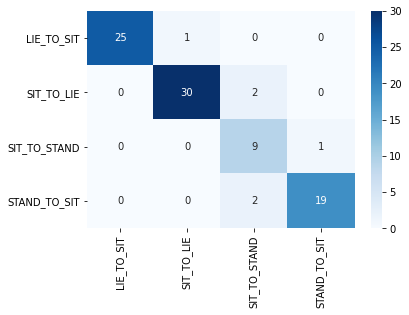

In [34]:
cf_matrix = confusion_matrix(y_test, y_pred)

categories = np.unique(y).tolist()
figsize = plt.rcParams.get('figure.figsize')
plt.figure(figsize=figsize)
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)